<a href="https://colab.research.google.com/github/whkaikai/CV-ML-Al/blob/main/%E7%81%B0%E5%BA%A6%E5%8F%98%E6%8D%A2_%E7%9B%B4%E6%96%B9%E5%9B%BE%E8%A7%84%E5%AE%9A%E5%8C%96.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**【功能】利用直方图规定化，保持原图色调的同时，增强图像暗部细节**

[INFO] matplotlib版本为：3.2.2
[0.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 4.0, 5.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 12.0, 13.0, 15.0, 17.0, 19.0, 21.0, 23.0, 26.0, 29.0, 32.0, 35.0, 38.0, 42.0, 46.0, 50.0, 54.0, 59.0, 64.0, 68.0, 73.0, 78.0, 84.0, 89.0, 94.0, 99.0, 104.0, 109.0, 114.0, 119.0, 124.0, 128.0, 132.0, 136.0, 140.0, 144.0, 148.0, 151.0, 154.0, 157.0, 159.0, 162.0, 164.0, 166.0, 168.0, 169.0, 171.0, 172.0, 173.0, 174.0, 175.0, 176.0, 177.0, 178.0, 179.0, 179.0, 180.0, 180.0, 181.0, 181.0, 182.0, 182.0, 183.0, 183.0, 183.0, 184.0, 184.0, 184.0, 185.0, 185.0, 185.0, 186.0, 186.0, 186.0, 187.0, 187.0, 187.0, 188.0, 188.0, 188.0, 189.0, 189.0, 190.0, 190.0, 190.0, 191.0, 191.0, 191.0, 192.0, 192.0, 192.0, 193.0, 193.0, 193.0, 194.0, 194.0, 194.0, 195.0, 195.0, 195.0, 196.0, 196.0, 196.0, 197.0, 197.0, 197.0, 198.0, 198.0, 198.0, 199.0, 199.0, 199.0, 200.0, 200.0, 200.0, 201.0, 201.0, 201.0, 202.0, 202.0, 202.0, 203.0, 203.0, 203.0, 204.0, 204.0, 204.0, 205.0, 205.0, 205.0, 206.0, 206.0, 206.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65306 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65292 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 65306 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 65292 missing from current font.
  font.set_text(s, 0, flags=flags)


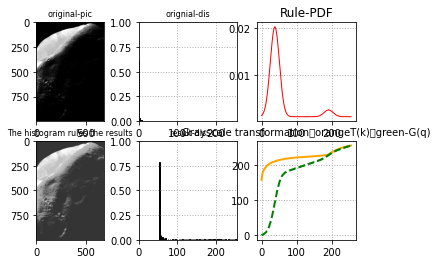

In [5]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# 中文设置函数
def set_chinese():
    import matplotlib
    print("[INFO] matplotlib版本为：%s" % matplotlib.__version__)
    matplotlib.rcParams['font.sans-serif'] = ['FangSong']
    matplotlib.rcParams['axes.unicode_minus'] = False

# 获取图像的概率密度
def get_pdf(in_img):
    total = in_img.shape[0] * in_img.shape[1] #计算图片总像素数
    return [ np.sum(in_img == i)/total for i in range(256) ] #求概率密度

# 直方图均衡化（核心代码）
def hist_equal(in_img):

    # 1.求原始图像的概率密度
    Pr = get_pdf(in_img)

    # 2.构造输出图像（初始化成输入）
    out_img = np.copy(in_img)

    # 3.执行“直方图均衡化”（执行累积分布函数变换）
    y_points = [] # 存储点集，用于画图
    SUMk = 0  # 累加值存储变量
    for i in range(256):
        SUMk = SUMk + Pr[i]
        out_img[(in_img == i)] = SUMk*255 #灰度值逆归一化
        y_points.append(SUMk*255) #构造绘制函数图像的点集（非核心代码，可忽略）

    return out_img.astype("int32"), y_points

# 生成均匀分布
def gen_eq_pdf():
    return [ 0.0039 for i in range(256) ] #均匀概率密度 1/256=0.0039

# 生成多峰正态分布
# means 各峰均值
# stds  各峰标准差
# ampl  各正态分布幅值（和为1）
# bias  概率密度函数总体抬升量（若没有抬升量，容易造成图像过暗）
def gen_mul_norm_pdf(x, means, stds, ampl, bias):
    pdf = np.zeros([256,], dtype=float)
    for i in range(len(means)):
        pdf_temp = ampl[i]*np.exp(-((x-means[i])**2)/(2*stds[i]**2))\
                   /(stds[i] * np.sqrt(2 * np.pi))
        pdf = pdf + pdf_temp
    pdf = pdf + bias #总体抬升概率密度，避免出现零值
    pdf2 = pdf/np.sum(pdf) #由于做了抬升，所以要重新归一化
    return pdf2.tolist()


# 构造目标图像的映射表（核心代码）
def gen_target_table(Pv):
    table = []
    SUMq = 0.
    for i in range(256):
        SUMq = SUMq + Pv[i]
        table.append(round(SUMq*255, 0))   #四舍五入
    return table

# 直方图规定化（核心代码）
def hist_specify(in_img=None):

    # 1.拿到目标图像规定概率密度,并构造映射表
    Pv = gen_mul_norm_pdf(np.arange(0,256,1),[38,191],[13,13],[0.93,0.07],0.002)
    table = gen_target_table(Pv)
    print(table)

    # 2.对原始图像做直方图均衡
    ori_eq_img, T_points = hist_equal(in_img)

    # 3.构造输出图像（初始化成输入）
    out_img = np.copy(ori_eq_img)

    # 4.执行“直方图规定化”（根据映射表，做逆映射 B'->B）
    map_val = 0  # 逆映射值初始化为0
    for v in range(256):
        if v in ori_eq_img: # 存在于B'
            if v in table:  # 存在于映射表
                map_val = len(table)-table[::-1].index(v)-1 #拿到指定值最后出现的索引
            out_img[(ori_eq_img == v)] = map_val # 找不到映射关系时，取前一个映射值

    return out_img, T_points, table, Pv




if __name__ == '__main__':

    set_chinese()

    # 读入原图
    gray_img = np.asarray(Image.open('/content/mars_moon_phobos.tif').convert('L'))

    # 对原图执行“直方图规定化”
    out_img, T_pts, G_pts, spec_hist = hist_specify(gray_img)

    # 创建1个显示主体，并分成6个显示区域
    fig = plt.figure()
    ax1, ax2, ax3 = fig.add_subplot(231), fig.add_subplot(232), fig.add_subplot(233)
    ax4, ax5, ax6 = fig.add_subplot(234), fig.add_subplot(235), fig.add_subplot(236)

    # 窗口显示：原图，原图灰度分布，规定PDF，结果图像，结果图像灰度分布，对应变换函数
    ax1.set_title('original-pic', fontsize=8)
    ax1.imshow(gray_img, cmap='gray', vmin=0, vmax=255)

    ax2.grid(True, linestyle=':', linewidth=1)
    ax2.set_title('orignial-dis', fontsize=8)
    ax2.set_xlim(0, 255)  # 设置x轴分布范围
    ax2.set_ylim(0, 1)  # 设置y轴分布范围
    ax2.hist(gray_img.flatten(),bins=255,density=True,color='black',edgecolor='black')

    ax4.set_title('The histogram rules the results', fontsize=8)
    ax4.imshow(out_img, cmap='gray', vmin=0, vmax=255)

    ax5.grid(True, linestyle=':', linewidth=1)
    ax5.set_title('result-dis', fontsize=8)
    ax5.set_xlim(0, 255)  # 设置x轴分布范围
    ax5.set_ylim(0, 1)  # 设置y轴分布范围
    ax5.hist(out_img.flatten(),bins=255,density=True,color='black',edgecolor='black')

    # 窗口显示：绘制规定概率密度函数
    ax3.set_title("Rule-PDF", fontsize=12)
    ax3.grid(True, linestyle=':', linewidth=1)
    ax3.plot(np.arange(0, 256, 1), spec_hist, color='r',lw=1)

    # 窗口显示：绘制对应的灰度变换函数
    ax6.set_title("Grayscale transformation：orangeT(k)，green-G(q)", fontsize=10)
    ax6.grid(True, linestyle=':', linewidth=1)
    ax6.plot(np.arange(0, 256, 1), T_pts, '-',color='orange',lw=2)
    ax6.plot(np.arange(0, 256, 1), G_pts, 'k--',color='green', lw=2)

    plt.show()


[INFO] matplotlib版本为：3.2.2


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65289 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 65288 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 65289 missing from current font.
  font.set_text(s, 0, flags=flags)


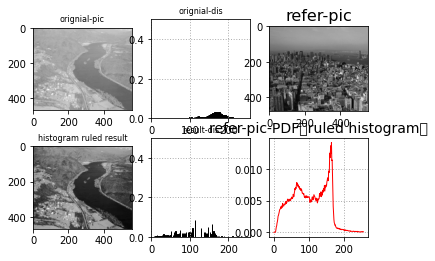

In [8]:
'''
【功能】通过参考无雾图像的规定直方图，实现类似去雾滤镜的效果。
'''
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

# 中文支持函数
def set_chinese():
    import matplotlib
    print("[INFO] matplotlib版本为：%s" % matplotlib.__version__)
    matplotlib.rcParams['font.sans-serif'] = ['FangSong']
    matplotlib.rcParams['axes.unicode_minus'] = False

# 获取图像的概率密度
def get_pdf(in_img):
    total = in_img.shape[0] * in_img.shape[1] #计算图片总像素数
    return [ np.sum(in_img == i)/total for i in range(256) ] #求概率密度

# 构造目标图像的映射表（核心代码）
def gen_target_table(Pv):
    table = []
    SUMq = 0.
    for i in range(256):
        SUMq = SUMq + Pv[i]
        table.append(round(SUMq*255, 0))   #四舍五入
    return table


# 直方图均衡化（核心代码）
def hist_equal(in_img):

    # 1.求原始图像的概率密度
    Pr = get_pdf(in_img)

    # 2.构造输出图像（初始化成输入）
    out_img = np.copy(in_img)

    # 3.执行“直方图均衡化”（执行累积分布函数变换）
    y_points = [] # 存储点集，用于画图
    SUMk = 0  # 累加值存储变量
    for i in range(256):
        SUMk = SUMk + Pr[i]
        out_img[(in_img == i)] = SUMk*255 #灰度值逆归一化
        y_points.append(SUMk*255) #构造绘制函数图像的点集（非核心代码，可忽略）

    return out_img.astype("int32"), y_points


# 直方图规定化（核心代码）
def hist_specify(in_img=None,ref_img=None):

    # 1.拿到目标图像规定的概率密度,并构造映射表
    Pv = get_pdf(ref_img) #从参考图像中拿到规定直方图
    table = gen_target_table(Pv)

    # 2.对原始图像做直方图均衡
    ori_eq_img, T_points = hist_equal(in_img)

    # 3.构造输出图像（初始化成输入）
    out_img = np.copy(ori_eq_img)

    # 4.执行“直方图规定化”（利用映射表，实现反映射）
    temp = 0
    for val in range(256):
        if val in ori_eq_img:
            if val in table:
                temp = len(table)-table[::-1].index(val)-1 #拿到指定值最后出现的索引
                #temp = table.index(val)  #index拿到指定值首次出现的索引
            out_img[(ori_eq_img == val)] = temp # 找不到映射关系时，取前一个映射值

    return out_img, T_points, table, Pv




if __name__ == '__main__':

    set_chinese()

    # 读入原图 和 参考图像
    gray_img = np.asarray(Image.open('/content/fog.png').convert('L'))
    ref_img = np.asarray(Image.open('/content/ref_de_fog.png').convert('L'))

    # 对原图执行“直方图规定化”
    out_img, T_pts, G_pts, spec_hist = hist_specify(gray_img,ref_img)
	
    # 创建1个显示主体，并分成6个显示区域
    fig = plt.figure()
    ax1, ax2, ax3 = fig.add_subplot(231), fig.add_subplot(232), fig.add_subplot(233)
    ax4, ax5, ax6 = fig.add_subplot(234), fig.add_subplot(235), fig.add_subplot(236)

    # 窗口显示：原图，原图灰度分布，结果图像，结果图像灰度分布
    ax1.set_title('orignial-pic', fontsize=8)
    ax1.imshow(gray_img, cmap='gray', vmin=0, vmax=255)

    ax2.grid(True, linestyle=':', linewidth=1)
    ax2.set_title('orignial-dis', fontsize=8)
    ax2.set_xlim(0, 255)  # 设置x轴分布范围
    ax2.set_ylim(0, 0.5)  # 设置y轴分布范围
    ax2.hist(gray_img.flatten(),bins=255,density=True,color='black',edgecolor='black')

    ax4.set_title('histogram ruled result', fontsize=8)
    ax4.imshow(out_img, cmap='gray', vmin=0, vmax=255)

    ax5.grid(True, linestyle=':', linewidth=1)
    ax5.set_title('result-dis', fontsize=8)
    ax5.set_xlim(0, 255)  # 设置x轴分布范围
    ax5.set_ylim(0, 0.5)  # 设置y轴分布范围
    ax5.hist(out_img.flatten(),bins=255,density=True,color='black',edgecolor='black')



    # 窗口显示：原图，原图灰度分布，结果图像，结果图像灰度分布
    ax3.set_title('refer-pic', fontsize=16)
    ax3.imshow(ref_img, cmap='gray', vmin=0, vmax=255)

    # 窗口显示：绘制规定概率密度函数
    ax6.set_title("refer-pic-PDF（ruled histogram）", fontsize=14)
    ax6.grid(True, linestyle=':', linewidth=1)
    ax6.plot(np.arange(0, 256, 1), spec_hist, color='r',lw=1)

    plt.show()
